# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Custom Modules.
from Game import Game
from Player import Player

# Custom Functions.
from RecursePlayer import recursePlayer,dealHouse,getReward,getValue
from Q_Learning import initQ,learnPolicy,evaluatePolicy,getBestAction
from Utils import dfBestMove

# Rewards Distribution

Given random gameplay, what are the expected reward for each state-action pair?

### Here, I can specifically state which combinations I want played. However, right now, I assume plentiful cards. Will not serve as optimal policy evaluation, but rather expected rewards given a state - action pair.

So, every combination is possible (hardcoded in), and the next card drawn is uniformly, with replacement. 

Might introduce some bias. Imagine player shows [2,2], the odds of them drawing another 2 should be lower, but this method does not say so.

I use discounted rewards. For example:
- Player shows 5, they hit to get 9, hit to get 12, hit to get 20, stay, and ends up winning the hand.
- I'm most interested in the move taken when player has 20.
- How I handle this is by using the gamma hyperparameter and discounting earlier moves more

Initialize the simulation

In [3]:
blackjack = Game(Player)
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

moves = ['stay','hit','double','surrender','split']

pairsSplit = {(c,c):i for i,c in enumerate(allCards)}
pairsSplit = {}
count = 0
for c in allCards :
    pairsSplit[(c,c)] = count
    if c not in [10,'J','Q'] :
        count += 1
    

# initialize arrays for totals + rewards
# dimensions are (m,a,p,h)
# - m : # of possible moves
# - a : useable ace or not
# - p : # of possible totals (includes 0,1,2,3 for simplicity), PLUS # of pairs
# - h : # of possible house face-up card (includes 0,1,2,3 for simplicity)

totals = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))
rewards = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))

gamma = .7

nTrials = 2000

Run the trail

In [4]:
for n in range(nTrials) :
    print('{} of {}'.format(n+1,nTrials),end='\r')
    for i in range(len(allCards)) :
        for j in range(i,len(allCards)) :
            cards = [allCards[i],allCards[j]]
            for h in range(len(allCards)) :
                houseCards,val,houseShow = dealHouse(allCards[h],cardMap,cardValues)
                seriesOut = recursePlayer(cards,allCards[h],cardMap,cardValues)

                for r in seriesOut :
                    if len(r)==0 :
                        totals[0,0,21,houseShow] += 1
                        rewards[0,0,21,houseShow] += 1.5
                        continue
                    reward = getReward(r,val)
                    
                    # I can discount earlier moves (hence reversing the order of moves)
                    # to more accurately reflect the benefit of hitting on smaller player cards shown.
                    for g,(playerShow,move,useableAce,pairSplit,nextVal) in enumerate(r[::-1]) :
                        indPlayer = playerShow
                        if pairSplit :
                            indPlayer = 22 + pairsSplit[tuple(pairSplit)]
                        totals[moves.index(move),int(useableAce),indPlayer,houseShow] += 1   
                        rewards[moves.index(move),int(useableAce),indPlayer,houseShow] += reward*gamma**g
            
            
normalized = np.zeros(totals.shape)
for m in range(len(moves)) :
    for i in [0,1] :
        # prevent division by zero, clip totals (shouldn't happen if # iterations is high enough)
        normalized[m][i] = rewards[m][i] / np.clip(totals[m][i],a_min=1,a_max=None)
            
            
        

In [5]:
#np.save('normalized.npy',normalized)
normalized = np.load('normalized.npy')

In [6]:
noAce,useableAce,canSplit = dfBestMove(normalized,moves,pairsSplit,colorBox=True)

In [7]:
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,St,St,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [8]:
useableAce

,2,3,4,5,6,7,8,9,10,11
13,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,Do,Do,Do,Do,Do,St,St,St,St,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St
21,St,St,St,St,St,St,St,St,St,St


In [9]:
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(4, 4)",Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
"(6, 6)",Sp,Sp,Sp,St,Sp,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,St,Sp,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,St,St,St,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Do,Do,Do,Sp,Sp,Sp,Sp,Sp


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
    - Always take the best action. In my code, it's equivalent to setting epsilon to -1
- Epsilon-Greedy Algorithm
    - With probability=epsilon, randomly take action. Otherwise, take best action
    - I allow epsilon to decay through learning. Meaning, Always explore at first, then start to exploit more.
- Thompson Sampling methods.
    - In my situation, this is handled by setting always_random=True
    - The probability of an action is chosen according to the learned Q value distribution over actions.
    - I normalize Q values by taking softmax of Q values.


I find that always_random=True leads to faster training than in epsilon decay.

I store "bestQ" at each interval of evaluation (expensive function, since I simulate 1000 rounds to evaluate).
So, Backtracking will be performed until number of rounds is complete.

#### Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [4]:
card_comb_all = []
card_comb = [[c1,c2] for i,c1 in enumerate(allCards) for c2 in allCards[i:]]
all_comb = [[c1,c2] for c1 in allCards for c2 in allCards]
for c in card_comb :
    for a in all_comb :
        card_comb_all.append([[c]]+[a])

In [8]:
Q = {
    'name':'e-Greedy Decay 1',
    'epsilon_decay':.00001,
    'min_epsilon':.1,
    'evaluation':[]
}

Q = {
    'name':'Q Sampling',
    'epsilon_decay':.00001,
    'min_epsilon':.1,
    'evaluation':[]
}

nEpisodes = int(2.5e6) # number of rounds to train for.
nPlayers = 1 # number of players
gamma = .9 # decay hyperparameter. How much to discount sequential actions. Should be < 1.
lr = .001 # learning rate
nDecks = 6 # number of decks in the game
ratioPenetrate = 4/6 # where the decks get penetrated, ie. 4/6'ths of the way through all decks
wagers = [1]*nPlayers # wagers per player "units"

nRoundsEvaluate = 2000 # number of hands to play during evaluation step

moves = ['stay','hit','split','double','surrender'] # valid moves.

earlyStop = False # whether we should early stop.
e = 10 # early stopping criterion. Number of "every" that have to pass without improvement.
# every = int(len(card_comb_all)/5) # interval to evaluate policy
every = 7500

# will intermittently store best Q values through evaluation
backtrack = False # whether to revert back to optimal Q values after training completes.

# will override epsilon value and sample from state-action space according to Q values.
always_random = True

# since some combinations are so rare, they are hardly explored. 
# Setting to True will force these combinations to be used.
# I have found that without hardcoding, there is hardly any information in some of the states.
# Introduces some unrealistic scenarios (allows for n_card < 0, which won't happen at inference)
allow_hardcoded_cards = False 


In [9]:
blackjack = Game(
    Player,
    allowHardCodedCards=allow_hardcoded_cards,
    shrinkDeck=True,
    nDecks=nDecks,
    ratioPenetrate=ratioPenetrate,
    verbose=False
)

allCards = list(blackjack.cardMap.values())
Q['Q'] = initQ(moves,allCards)

time_start = datetime.datetime.now()

r = 0
counter = 0
minPerformance = -10

while r < nEpisodes :
    
    # force exploration of space
    # since some combinations were never occuring, I still want some notion of how to move.
    # introduces some "error", as it's possible not enough cards are in the deck.
    # I say it's acceptable for 1 move, then a reshuffling will occur after.
    # I see better learning with this method anyways.
    card_comb_use = card_comb_all[r%len(card_comb_all)]

    blackjack.initRound(wagers)
    if allow_hardcoded_cards :
        blackjack.dealInit(hardcodedCards=card_comb_use) # force certain cards to be explored.
    else :
        blackjack.dealInit()
    if not blackjack.houseBlackjack :
        eps = max(Q['min_epsilon'],np.exp(-Q['epsilon_decay']*r)) #exponential decay factor.
        learnPolicy(blackjack,Q['Q'],nPlayers,eps,gamma,lr,always_random=always_random)

    if not r%every :
        blackjackEval = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
        # Evaluation. This represents the avg reward, per hand, for the number of rounds specified.
        p = np.mean(evaluatePolicy(blackjackEval,Q['Q'],wagers,nRoundsEvaluate)[-1])
        Q['evaluation'].append(p)
        
        if not always_random :
            print('Method {} ---- {} of {} ---- EPS : {} ---- Score : {}'.format(
                Q['name'],
                r+1,
                nEpisodes,
                eps,
                p
            ))
        else :
            print('Method {} ---- {} of {} ---- Score : {} ---- Time elapsed : {}'.format(
                Q['name'],
                r+1,
                nEpisodes,
                p,
                datetime.datetime.now() - time_start
            ))

        if p < minPerformance : 
            counter += 1
        else :
            counter = 0
            if backtrack :
                bestQ = Q['Q'].copy() # "backtracking". This will be used as optimal Q value dict. 
        minPerformance = max(minPerformance,p)

    if (earlyStop) & (counter == e) :

        print('Early Stopping at Round {}.'.format(r))
        break

    r += 1
if not backtrack : # without backtracking, just take final Q values.
    bestQ = Q['Q'].copy()

Method Q Sampling ---- 1 of 2500000 ---- Score : -0.4345 ---- Time elapsed : 0:00:00.557524
Method Q Sampling ---- 7501 of 2500000 ---- Score : -0.0615 ---- Time elapsed : 0:00:03.224083
Method Q Sampling ---- 15001 of 2500000 ---- Score : -0.071 ---- Time elapsed : 0:00:05.905573
Method Q Sampling ---- 22501 of 2500000 ---- Score : -0.058 ---- Time elapsed : 0:00:08.547834
Method Q Sampling ---- 30001 of 2500000 ---- Score : -0.0335 ---- Time elapsed : 0:00:11.215104
Method Q Sampling ---- 37501 of 2500000 ---- Score : -0.01675 ---- Time elapsed : 0:00:13.876682
Method Q Sampling ---- 45001 of 2500000 ---- Score : -0.04875 ---- Time elapsed : 0:00:16.574670
Method Q Sampling ---- 52501 of 2500000 ---- Score : -0.0075 ---- Time elapsed : 0:00:19.258874
Method Q Sampling ---- 60001 of 2500000 ---- Score : -0.0725 ---- Time elapsed : 0:00:21.980409
Method Q Sampling ---- 67501 of 2500000 ---- Score : -0.01125 ---- Time elapsed : 0:00:24.642931
Method Q Sampling ---- 75001 of 2500000 ----

Method Q Sampling ---- 637501 of 2500000 ---- Score : -0.022 ---- Time elapsed : 0:03:47.546330
Method Q Sampling ---- 645001 of 2500000 ---- Score : -0.047 ---- Time elapsed : 0:03:50.203326
Method Q Sampling ---- 652501 of 2500000 ---- Score : -0.02525 ---- Time elapsed : 0:03:52.875475
Method Q Sampling ---- 660001 of 2500000 ---- Score : -0.01075 ---- Time elapsed : 0:03:55.521620
Method Q Sampling ---- 667501 of 2500000 ---- Score : 0.027 ---- Time elapsed : 0:03:58.204805
Method Q Sampling ---- 675001 of 2500000 ---- Score : 0.00575 ---- Time elapsed : 0:04:00.852477
Method Q Sampling ---- 682501 of 2500000 ---- Score : 0.0225 ---- Time elapsed : 0:04:03.505343
Method Q Sampling ---- 690001 of 2500000 ---- Score : -0.00125 ---- Time elapsed : 0:04:06.175122
Method Q Sampling ---- 697501 of 2500000 ---- Score : 0.0115 ---- Time elapsed : 0:04:08.872482
Method Q Sampling ---- 705001 of 2500000 ---- Score : 0.0545 ---- Time elapsed : 0:04:11.547593
Method Q Sampling ---- 712501 of 2

Method Q Sampling ---- 1275001 of 2500000 ---- Score : -0.00825 ---- Time elapsed : 0:07:34.824703
Method Q Sampling ---- 1282501 of 2500000 ---- Score : 0.0155 ---- Time elapsed : 0:07:37.495044
Method Q Sampling ---- 1290001 of 2500000 ---- Score : 0.00425 ---- Time elapsed : 0:07:40.190926
Method Q Sampling ---- 1297501 of 2500000 ---- Score : -0.03625 ---- Time elapsed : 0:07:42.869837
Method Q Sampling ---- 1305001 of 2500000 ---- Score : -0.01425 ---- Time elapsed : 0:07:45.576542
Method Q Sampling ---- 1312501 of 2500000 ---- Score : -0.003 ---- Time elapsed : 0:07:48.247152
Method Q Sampling ---- 1320001 of 2500000 ---- Score : 0.018 ---- Time elapsed : 0:07:50.966706
Method Q Sampling ---- 1327501 of 2500000 ---- Score : -0.01125 ---- Time elapsed : 0:07:53.640191
Method Q Sampling ---- 1335001 of 2500000 ---- Score : -0.0195 ---- Time elapsed : 0:07:56.323946
Method Q Sampling ---- 1342501 of 2500000 ---- Score : -0.02 ---- Time elapsed : 0:07:58.967662
Method Q Sampling ----

Method Q Sampling ---- 1912501 of 2500000 ---- Score : 0.0305 ---- Time elapsed : 0:11:23.581065
Method Q Sampling ---- 1920001 of 2500000 ---- Score : 0.04275 ---- Time elapsed : 0:11:26.320148
Method Q Sampling ---- 1927501 of 2500000 ---- Score : 0.00725 ---- Time elapsed : 0:11:29.011728
Method Q Sampling ---- 1935001 of 2500000 ---- Score : -0.019 ---- Time elapsed : 0:11:31.672080
Method Q Sampling ---- 1942501 of 2500000 ---- Score : 0.0155 ---- Time elapsed : 0:11:34.358124
Method Q Sampling ---- 1950001 of 2500000 ---- Score : 0.00725 ---- Time elapsed : 0:11:37.031468
Method Q Sampling ---- 1957501 of 2500000 ---- Score : -0.01525 ---- Time elapsed : 0:11:39.733546
Method Q Sampling ---- 1965001 of 2500000 ---- Score : -0.04475 ---- Time elapsed : 0:11:42.393761
Method Q Sampling ---- 1972501 of 2500000 ---- Score : 0.0255 ---- Time elapsed : 0:11:45.092187
Method Q Sampling ---- 1980001 of 2500000 ---- Score : -0.049 ---- Time elapsed : 0:11:47.744918
Method Q Sampling ---- 

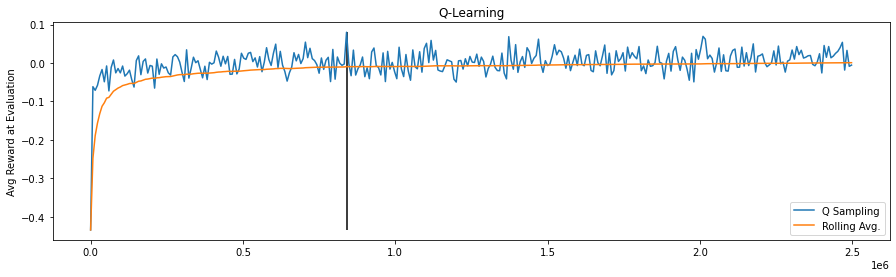

In [12]:
plt.figure(figsize=(15,4))
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    Q['evaluation'],
    label=Q['name']
)
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    np.cumsum(Q['evaluation']) / np.arange(1,len(Q['evaluation'])+1),
    label='Rolling Avg.'
)
plt.vlines(x=np.argmax(Q['evaluation'])*every,ymin=min(Q['evaluation']),ymax=max(Q['evaluation']),color='k')
plt.title("Q-Learning")
plt.ylabel("Avg Reward at Evaluation")
plt.legend()
plt.show()

In [14]:
np.save('Q',bestQ)
Qlearned = np.load('Q.npy',allow_pickle=True).item()

### Evaluate new policy, as well as a random one, and a simple one.

It is apparent that the learned policy performs better in practice than a random one, and a "simple" one. In the "simple" one, I create a basic strategy where the player hits until they have >17

In [15]:
# I found online that this gameplay was optimal.

acceptedQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in acceptedQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=="canSplit" :
            if p == "A" :
                p = 11
            if p <= 3 :
                if h <= 7 :
                    vals["split"] = 1
                else :
                    vals["hit"] = 1
            if p == 4 :
                if h in [5,6] :
                    vals["split"] = 1
                else :
                    vals["hit"] = 1
            if p == 5 :
                if h <= 9 :
                    vals["double"] = 1
                else :
                    vals["hit"] = 1
            if p == 6 :
                if h <= 6 :
                    vals["split"] = 1
                else :
                    vals["hit"] = 1
            if p == 7 :
                if h <= 7 :
                    vals["split"] = 1
                else :
                    vals["hit"] = 1
            if p == 8 :
                vals["split"] = 1
            if p == 9 :
                if h in [2,3,4,5,6,8,9] :
                    vals["split"] = 1
                else :
                    vals["stay"] = 1
            if p == 10 :
                vals["stay"] = 1
            if p == 11 :
                vals["split"] = 1
        else :
            if not a :
                if p <= 8 :
                    vals["hit"] = 1
                if p == 9 :
                    if h in [2,7,8,9,10,11] :
                        vals["hit"] = 1
                    else :
                        vals["double"] = 1
                if p == 10 :
                    if h <= 9 :
                        vals["double"] = 1
                    else :
                        vals["hit"] = 1
                if p == 11 :
                    vals["double"] = 1
                if p == 12 :
                    if 4 <= h <= 6 :
                        vals["stay"] = 1
                    else :
                        vals["hit"] = 1
                if p in [13,14] :
                    if h <= 6 :
                        vals["stay"] = 1
                    else :
                        vals["hit"] = 1
                if p == 15 :
                    if h <= 6 :
                        vals["stay"] = 1
                    else :
                        if h == 10 :
                            vals["surrender"] = 1
                        else :
                            vals["hit"] = 1
                if p == 16 :
                    if h <= 6 :
                        vals["stay"] = 1
                    else :
                        if h >= 9 :
                            vals["surrender"] = 1
                        else :
                            vals["hit"] = 1
                if p >= 17 :
                    vals["stay"] = 1
            else :
                if p in [13,14] :
                    if h in [5,6] :
                        vals["double"] = 1
                    else :
                        vals["hit"] = 1
                if p in [15,16] :
                    if h in [4,5,6] :
                        vals["double"] = 1
                    else :
                        vals["hit"] = 1
                if p == 17 :
                    if h in [3,4,5,6] :
                        vals["double"] = 1
                    else :
                        vals["hit"] = 1
                if p == 18 :
                    if h <= 6 :
                        vals["double"] = 1
                    else :
                        if h <= 8 :
                            vals["stay"] = 1
                        else :
                            vals["hit"] = 1
                if p == 19 :
                    if h == 6 :
                        vals["double"] = 1
                    else :
                        vals["stay"] = 1
                if p == 20 :
                    vals["stay"] = 1  

Generating Random Rewards...
Generating Learned Rewards Deterministically...
Generating Accepted Rewards... (found online to be optimal play)
Generating Meh Rewards...
Done


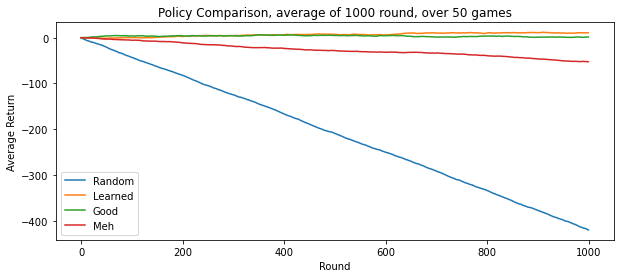

In [20]:
nRoundsEvaluate = 1000 # number of rounds to play
nIterations = 50 # number of times to play above number of rounds (average is taken)

print('Generating Random Rewards...')
randQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
randomRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,randQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)

print('Generating Learned Rewards Deterministically...')
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
except :
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
    
print("Generating Accepted Rewards... (found online to be optimal play)")
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
acceptedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,acceptedQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
    
print('Generating Meh Rewards...')
somewhatSmartQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in somewhatSmartQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=='canSplit' :
            if p == 'A' :
                p = 12
            else :
                p = p*2
        if p >= 17 :
            vals['stay'] = 1
        else :
            vals['hit'] = 1

blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
mehRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,somewhatSmartQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)
print('Done')

plt.figure(figsize=(10,4))
plt.title(f'Policy Comparison, average of {nRoundsEvaluate} round, over {nIterations} games')
plt.plot(randomRewards,label='Random')
plt.plot(learnedRewards,label='Learned')
plt.plot(acceptedRewards,label='Good')
plt.plot(mehRewards,label='Meh')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

Focusing in on learned + accepted policies


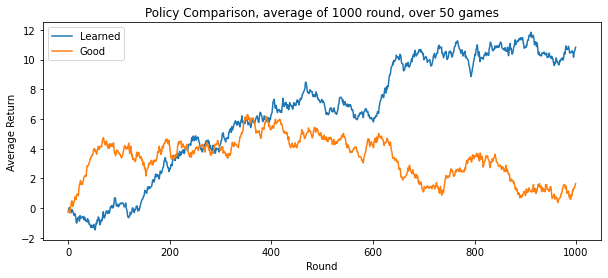

In [21]:
print("Focusing in on learned + accepted policies")
plt.figure(figsize=(10,4))
plt.title(f'Policy Comparison, average of {nRoundsEvaluate} round, over {nIterations} games')
plt.plot(learnedRewards,label='Learned')
plt.plot(acceptedRewards,label='Good')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

In [22]:
print("We can observe the Expected Value of Blackjack following these policies:")
print("This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)\n")
print("Play Randomly:")
print(f"\t{(randomRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Mimicing the House:")
print(f"\t{(mehRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Following Accepted Policy:")
print(f"\t{(acceptedRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")
print("Following Learned Policy:")
print(f"\t{(learnedRewards[-1]/nRoundsEvaluate):.4f} units net per round\n")

We can observe the Expected Value of Blackjack following these policies:
This takes into account the effect of doubling down, splitting, and blackjacks (impacting wager / winnings)

Play Randomly:
	-0.4201 units net per round

Mimicing the House:
	-0.0525 units net per round

Following Accepted Policy:
	0.0016 units net per round

Following Learned Policy:
	0.0108 units net per round



### While sampling helped in training Q values, it's clear that we should deterministically take actions best on best Q value at that state/action pair.

Below, I show the cummulative rewards for a different players playing blackjack for many rounds according to our learned policy.

There is clearly a ton of randomness going on. This is the nature of blackjack.

Important to note that we are able to minimize risk through this learned policy. We go from a net -0.4 units lost per round with a random policy, to achieving what seems to be no-loss per round, on average.

**This doesn't even take card count into account**

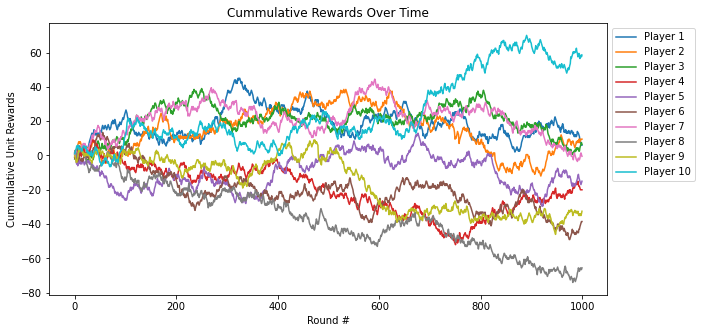

In [33]:
plt.figure(figsize=(10,5))

for i in range(10) :
    blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
    try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
        r = np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0])
    except :
        r = np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0])
    plt.plot(r,label='Player {}'.format(i+1))
plt.legend(bbox_to_anchor=[1, 1])
plt.title('Cummulative Rewards Over Time')
plt.xlabel('Round #')
plt.ylabel('Cummulative Unit Rewards')
plt.show()

### Give an example of playing a hand according to learned policy.

You can see the sequence of events taken by the player, the sequence of events taken by the house, the outcome, and the unit reward

In [81]:
blackjack = Game(Player,verbose=False)

blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)

print('Player Cards / Moves:')
while not player.isDone() :

    playerShow,canSplit,useableAce,card1 = player.getValue()

    policy = player.getValidMoves(houseShow)
    policy = [p for p in policy if p!='insurance']
    try :
        if canSplit :
            move = getBestAction(Qlearned['canSplit'][(card1,houseShow,useableAce)],policy,-1,False)
        else :
            move = getBestAction(Qlearned['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,False)
    except :
        if canSplit :
            move = getBestAction(bestQ['canSplit'][(card1,houseShow,useableAce)],policy,-1,False)
        else :
            move = getBestAction(bestQ['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,False)
    print(player.cards,move)
    
    blackjack.stepPlayer(player,move)

if move != 'stay' :
    print(player.cards)

blackjack.stepHouse()

print('\nHouse Cards / Moves:')
print(blackjack.house.cards)
print('\nResult:')
blackjack.getResults()

Player Cards / Moves:
[[3, 6]] hit
[[3, 6, 2]] hit
[[3, 6, 2, 6]] stay

House Cards / Moves:
[['K', 'J']]

Result:


([['loss']], [-1])

## Evaluation

In [24]:
Qlearned = np.load('Q.npy',allow_pickle=True).item()

In [25]:
fill = np.empty((3,21+1,11+1),dtype='O')
value_det = np.zeros((3,21+1,11+1))

### First I can show the Value function

Two ways:
- Deterministic Action. Select best action. ie. P=1 for best action, else P=0
- Random Action. Best action is selected according to normalized q values

$V_{\pi}(s)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$
$$
V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]
$$

$Q_{\pi}(s,a)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$ and take action $a$
$$
Q_{\pi}(s,a) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right]
$$

We can relate $V$ and $Q$ by taking marginal expections over $a$

$$V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]$$

$$V_{\pi}(s) = E_a\left[E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right] \right]$$

$$V_{\pi}(s) = E_a\left[Q_{\pi}(s,a)\right]$$

$$V_{\pi}(s) = \sum_{a}\pi(s,a)Q(s,a)$$

Where $\pi(s,a)$ is the probability of taking action $a$ in state $s$

In my case, I allow for randomization in action during Q learning. However, in evaluation, I always take the optimal action, which is deterministic

In practice, the action is taken that maximizes the Q value given the current state, deterministically.

In [26]:
# Two ways to define value function
# 1. Deterministic. Pick best action
# 2. Random. Pick best action according to probability, which is normalized from possible q-values

for k,v in Qlearned['noSplit'].items() :
    p,h,a = k
    fill[int(a),p,h] = max(v,key=v.get)[:2].title()
    value_det[int(a),p,h] = max(v.values()) # Deterministic    
for k,v in Qlearned['canSplit'].items() :
    p,h,a = k
    if not isinstance(p,int) :
        p = 11
    fill[2,p,h] = max(v,key=v.get)[:2].title()
    value_det[2,p,h] = max(v.values()) # Deterministic    

### Below I am plotting 3d visualizations of our Reward function.

#### We assume that the P=1 for taking the best action, and P=0 otherwise. We don't learn transition probabilities in this model-free method, so we always take the best action in our environment

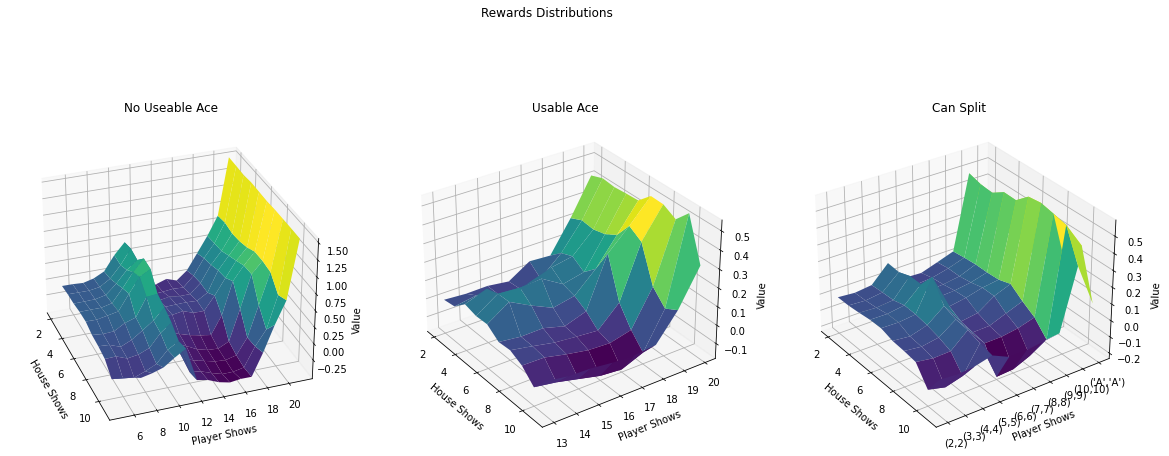

In [34]:
fig = plt.figure(figsize=(20,8))
fig.suptitle('Rewards Distributions')
ax = fig.add_subplot(131, projection='3d')
ax.set_title('No Useable Ace')

noAceMesh = value_det[0][5:,2:]
x,y = np.meshgrid(range(2,12),range(5,22))
ax.plot_surface(x, y, noAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-20)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

ax = fig.add_subplot(132, projection='3d')
ax.set_title('Usable Ace')
usableAceMesh = value_det[1][13:21,2:]
x,y = np.meshgrid(range(2,12),range(13,21))

ax.plot_surface(x, y, usableAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

ax = fig.add_subplot(133, projection='3d')
ax.set_title('Can Split')

canSplitMesh = value_det[2][2:12,2:]
x,y = np.meshgrid(range(2,12),range(2,12))
ticks = ["({},{})".format(p,p) if p < 11 else "('A','A')" for p in range(2,12)]
ax.set(yticks=range(2,12), yticklabels=ticks)
ax.plot_surface(x, y, canSplitMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')

plt.subplots_adjust(hspace=0, wspace=0.2)

plt.show()

In [35]:
colorMap = {'St':'blue','Hi':'green','Do':'red','Su':'grey','Sp':'yellow'}
noAce = pd.DataFrame(fill[0])
noAce = noAce.iloc[5:][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,Hi,Hi,Hi,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi


In [36]:
usableAce = pd.DataFrame(fill[1])
usableAce = usableAce.iloc[13:21][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
usableAce

,2,3,4,5,6,7,8,9,10,11
13,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi,Hi
17,Do,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,St,St,St,St,Do,St,St,Hi,Hi,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [37]:
canSplit = pd.DataFrame(fill[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ('A','A') for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: 'background-color: %s' % colorMap[x])
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Hi,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Hi
"(4, 4)",Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,Sp,Sp,Sp
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


## Next, I want to incorporate "card count" into the model. This makes the space too large. The solution to this is approximating the Q learning function, through deep learning methods.